In [1]:
# Importing packages
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
from statsmodels.tsa.stattools import adfuller
import warnings
# Suppress all warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import zscore

# Loading data
df = pd.read_csv('initial_data2.csv')

# Converting Date column to Datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Introduction 

Using a CDC database of weekly-reported vaccine equity data at an United States state level, we seek to predict the percent of people in a county who have completed a primary series of a vaccination and received a booster dose. This data will be cleaned and organized for use on a dashboard and time series prediction. Some of the predictors for this project include demographic data on a state level and specific data on the vaccination rates of specific age groups. 
The dashboard will contain graphs showing the vaccinated proportion of Illinois county populations utilizing visual map tools for ease of use by stakeholders. Users of the dashboard may include vaccine manufacturers who are seeking data on specific geographical places or demographics that they should target their advertisement towards. For example, should our analysis reveal that high vaccination rates among children under 12 strongly correlate with overall vaccination coverage, manufacturers might be influenced to focus their marketing efforts on families. Additionally, the map feature on our dashboard will help these manufacturers identify states in the United States that are currently underserved, enabling more strategic decision-making.


# Data Preparation

### 1. Data Collection:

We are using data collected by the Centers for Disease Control and Prevention (CDC). These data are made accessible through the CDC’s Application Programming Interface (API). For our dashboard, we may choose to integrate more demographic data from an alternative source to depict demographics on a state level.

### 2. Data Cleaning:
#### Imputing missing values and removing redundant features

Our goal for this project is to predict the percentage of the population that has received the initial booster. With this objective in mind, we identified missing data, deleted redundant columns, and investigated outliers. We eliminated features with more than 1,000 missing values, as they relate to the bivalent booster or second booster distribution. The second booster was introduced about a year after the initial booster. To avoid data leakage, we ensured that data regarding the second booster doses are absent, given that these vaccines weren't available at the commencement of our dataset.

Columns existed for both the proportion of people in a state who had been vaccinated and the actual number who received the vaccine. Since these essentially measured the same metric, albeit at different scales, we felt it redundant. Hence, we discarded the count features and retained the proportion columns, ensuring consistent scaling across states.

Furthermore, a significant portion of data before November 2nd, 2021, was missing. Research revealed that this date aligned with the CDC’s recommendation for children aged five to eleven to receive the vaccine (Kates et al., 2021). This led us to adjust our dataset's starting point to this date for consistency. We observed a significant number of missing entries for December 14th, 2022. While the cause remains unclear, our research into time series imputation techniques led us to select the Last Observation Carried Forward (LOCF) method (Abulkhair, 2023). Consequently, we used the data from December 7th, 2022, to fill the gaps for those states with incomplete data on December 14th, 2022.

In [2]:
#### Data Preparation and Cleaning

# find na value counts
missing_counts = df.isna().sum()

# Sort the missing value counts in descending order
missing_counts_sorted = missing_counts.sort_values(ascending=False)

# columns with over 1000 missing values
columns_with_over_1000_missing = missing_counts_sorted[missing_counts_sorted > 1000].index

# remove columns with over 1000 missing
df = df.drop(columns=columns_with_over_1000_missing)

# list of numerical columns wihh equivalent percentage columns to drop
columns_to_drop = [
       'Administered_Dose1_Recip',   
       'Administered_Dose1_Recip_5Plus',
       'Administered_Dose1_Recip_12Plus',  
       'Administered_Dose1_Recip_18Plus',
       'Administered_Dose1_Recip_65Plus', 
        'Series_Complete_Yes',
        'Series_Complete_5Plus',
        'Series_Complete_12Plus',
        'Series_Complete_18Plus',
       'Series_Complete_65Plus',
       'Additional_Doses_18Plus', 
       'Additional_Doses_50Plus', 
       'Additional_Doses_65Plus']

# Dropping the columns from the df
df = df.drop(columns = columns_to_drop)

# Defining response variable for easier 
pred_var = 'Additional_Doses_Vax_Pct' 

given_date = pd.to_datetime('2021-11-02') 

df = df[df['Date'] > given_date]

specific_day = '2022-12-14'  

specific_day_data = df.loc[df['Date'] == specific_day]

rows_with_missing_values = specific_day_data[specific_day_data.isnull().any(axis=1)]


location_values = rows_with_missing_values['Location'].tolist()

# Month column
df['month'] = df['Date'].dt.month

# Year column
df['year'] = df['Date'].dt.year

# Filter the DataFrame for dates in December 2022
december_2022_data = df[(df['year'] == 2022) & (df['month'] == 12)]

for location in location_values:
    # Subset data for the specific location
    location_data = df[df['Location'] == location]
    
    # Subset data for the specific dates
    dates_to_impute = location_data[location_data['Date'].isin(['2022-12-07', '2022-12-14'])]
    
    # Perform forward fill (LOCF) imputation for the specific location and dates
    imputed_data = dates_to_impute.bfill()
    
    # Update the original DataFrame with the imputed data for the current location
    df.loc[imputed_data.index, imputed_data.columns] = imputed_data

### 3. Temporal Aggregation:

Upon deeper data analysis, we discovered a shift in June 2022, where the API transitioned from daily to weekly reporting. To maintain consistency, we chose to resample our dataset to capture weekly observations every Wednesday, aligning with the reporting pattern post-June 2022.

In [4]:
june_2022_data = df[(df['year'] == 2022) & (df['month'] == 6)]

dec_2021_data = df[(df['year'] == 2021) & (df['month'] == 12)]

df['day_of_week'] = df['Date'].dt.day_name()

# Identifying day of week
given_date = pd.to_datetime('2022-06-22') 
days = df[df['Date'] > given_date]

df = df[df['day_of_week'] == 'Wednesday']

### 4. Outlier Detection
#### Segmented Analysis Outlier Detection on Aggregated Data

For outlier detection, we used the average for each feature across observations for each date so that we could make the date the index. We decided to use segmented analysis for outlier detection which breaks the dataset into monthly segments and calculates the IQR for each segment. This can help identify if outliers are specific to certain months because the rate of vaccination varies greatly month-to-month. Using this technique, we did not identify any outliers in our dataset.

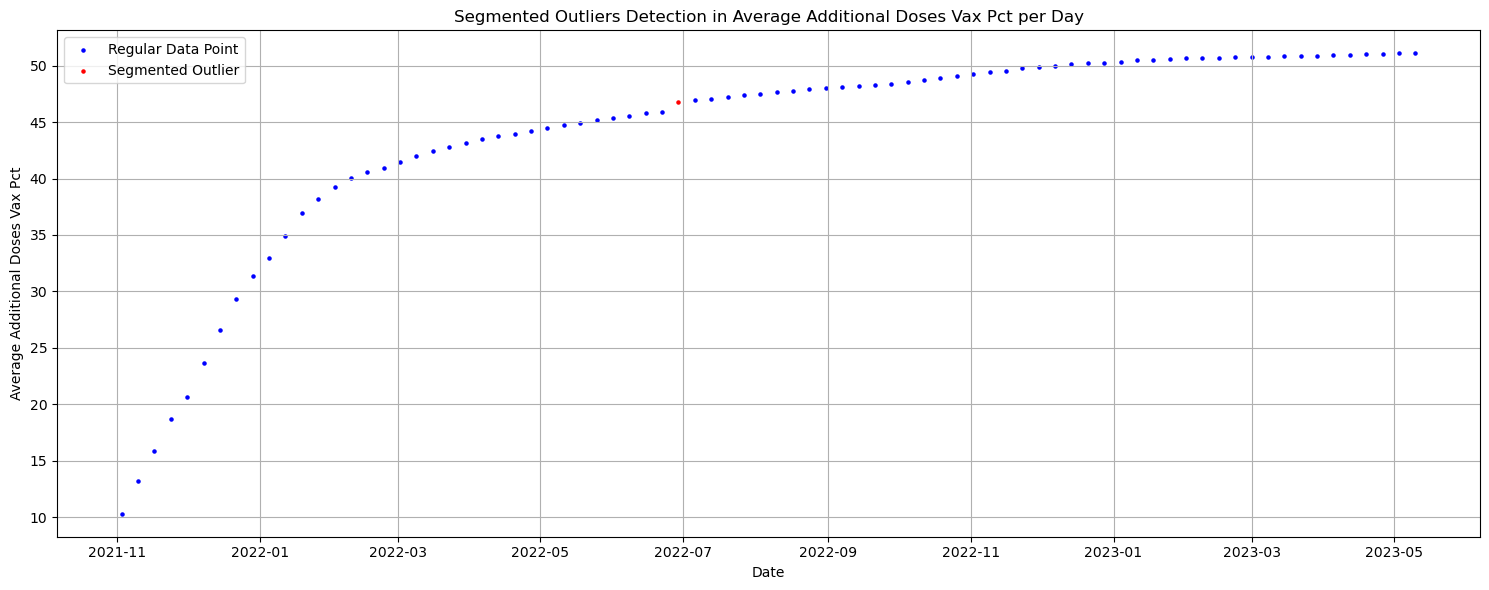

In [4]:
avg_vax_pct_per_day = df.groupby('Date')['Additional_Doses_Vax_Pct'].mean().reset_index()
# Convert 'Date' to datetime format
avg_vax_pct_per_day['Date'] = pd.to_datetime(avg_vax_pct_per_day['Date'])

# Create a month-year column for segmentation
avg_vax_pct_per_day['Month_Year'] = avg_vax_pct_per_day['Date'].dt.to_period('M')

# Group by Month_Year and calculate IQR for each month
iqr_values = avg_vax_pct_per_day.groupby('Month_Year')['Additional_Doses_Vax_Pct'].apply(lambda x: (x.quantile(0.25), x.quantile(0.75))).reset_index()
iqr_values.columns = ['Month_Year', 'IQR_Values']
iqr_values['Q1'] = iqr_values['IQR_Values'].apply(lambda x: x[0])
iqr_values['Q3'] = iqr_values['IQR_Values'].apply(lambda x: x[1])
iqr_values['Lower_Bound'] = iqr_values['Q1'] - 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])
iqr_values['Upper_Bound'] = iqr_values['Q3'] + 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])

# Merge the IQR values back to the main dataframe
avg_vax_pct_per_day = pd.merge(avg_vax_pct_per_day, iqr_values, on='Month_Year')

# Determine if a data point is an outlier for its respective month
avg_vax_pct_per_day['is_segmented_outlier'] = (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] < avg_vax_pct_per_day['Lower_Bound']) | (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] > avg_vax_pct_per_day['Upper_Bound'])
# Scatter plot to see segmented analysis outliers
plt.figure(figsize=(15, 6))

# Plot non-outliers in blue and outliers in red
plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Date'], 
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Additional_Doses_Vax_Pct'], 
            color='blue', s=5, label='Regular Data Point')

plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Date'], 
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Additional_Doses_Vax_Pct'], 
            color='red', s=5, label='Segmented Outlier')

plt.title('Segmented Outliers Detection in Average Additional Doses Vax Pct per Day')
plt.xlabel('Date')
plt.ylabel('Average Additional Doses Vax Pct')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Segmented Analysis Outlier Detection on State-Level Data
We wanted to see if there are any outliers in the data at large (multiple observations on the same day). We can see there are some in the first eight months of data collection. 

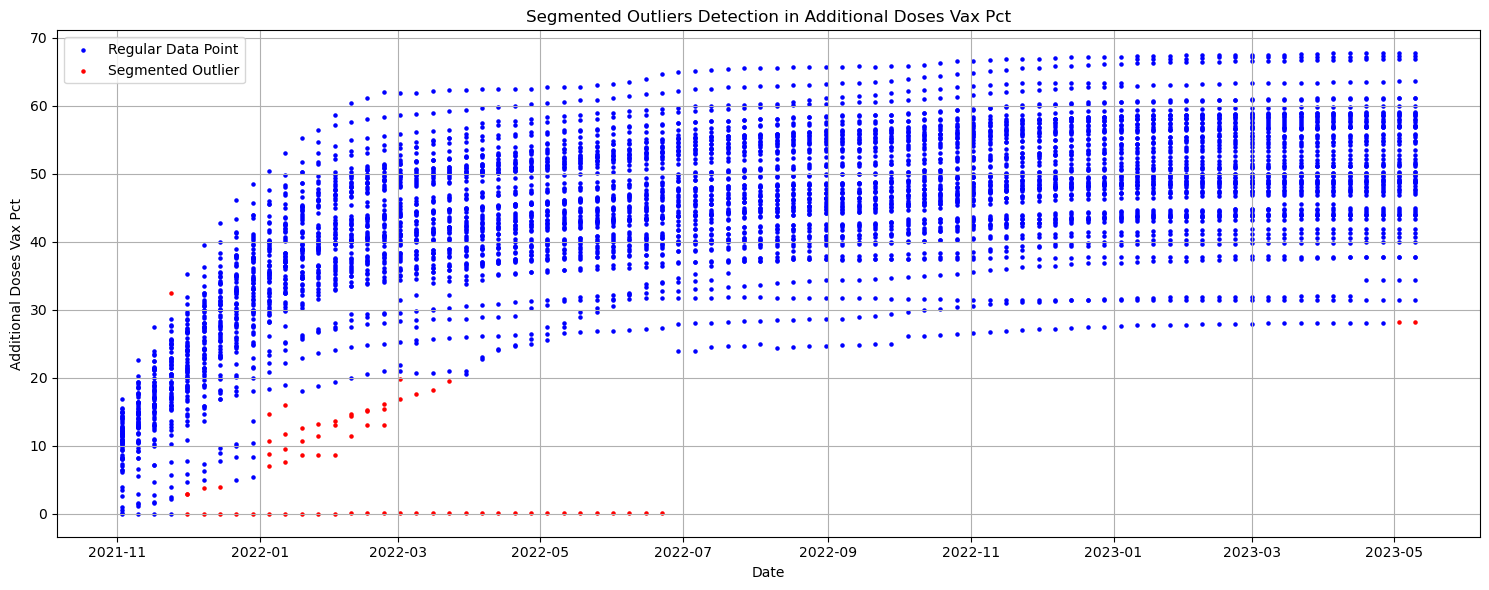

In [5]:
# Split the dataframe based on month
dff = df # Creating separate df just for visualization purpose
dff['YearMonth'] = dff['Date'].dt.to_period('M')
segments = dff.groupby('YearMonth')

# Placeholder for outlier identification
dff['is_segmented_outlier'] = False

# For each segment, determine the outliers using the IQR method
for _, segment in segments:
    Q1 = segment['Additional_Doses_Vax_Pct'].quantile(0.25)
    Q3 = segment['Additional_Doses_Vax_Pct'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    
    # Mark outliers in the original dataframe
    dff.loc[segment.index, 'is_segmented_outlier'] = (segment['Additional_Doses_Vax_Pct'] < lower_bound) | (segment['Additional_Doses_Vax_Pct'] > upper_bound)

# Scatter plot
plt.figure(figsize=(15, 6))

# Plot non-outliers in blue and outliers in red
plt.scatter(dff[dff['is_segmented_outlier'] == False]['Date'], 
            dff[dff['is_segmented_outlier'] == False]['Additional_Doses_Vax_Pct'], 
            color='blue', s=5, label='Regular Data Point')

plt.scatter(dff[dff['is_segmented_outlier'] == True]['Date'], 
            dff[dff['is_segmented_outlier'] == True]['Additional_Doses_Vax_Pct'], 
            color='red', s=5, label='Segmented Outlier')

plt.title('Segmented Outliers Detection in Additional Doses Vax Pct')
plt.xlabel('Date')
plt.ylabel('Additional Doses Vax Pct')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 5. Feature Engineering:

In our time-series analysis, we recognized the value of feature engineering to uncover potential predictors not explicitly present in the CDC’s API. Consequently, we integrated columns indicating the quarter, month, year, day of the week, day of the month, day of the year, and week of the year the observation was taken. Additionally, we established columns denoting the season of the observation (Winter, Spring, Fall, or Summer). We incorporated a Boolean column to indicate if the week of the observation encompassed a holiday, as per the `holidays` Python library, and another to denote if it contained a vaccine announcement by the CDC (Montel, 2017; Hahn, n.d.).

To explore time trends in prediction variables over time, we have had to group the data by date. This was necessary as otherwise the data contains multiple entries for each date for each state. To investigate lag we have plotted an ACF graph. The pattern the ACF plot exhibited is commonly observed in time series data with a strong short-term memory or persistence. It implied that the most recent values have a more pronounced impact on the current value, and the impact of earlier values diminishes gradually. The decay in autocorrelation suggests a relatively fast decrease in correlation with increasing time lags. To further investigate the lag we have plotted the PACF graph which showed the most significant lag at value of 1. Thus we have created a lag variable with shift of 1. Notably, autoregressive integrated moving average (ARIMA) models intrinsically factor in such dependencies.

In [5]:
# Quarter column
df['quarter'] = df['Date'].dt.quarter

# Day of year column
df['dayofyear'] = df['Date'].dt.dayofyear

# Day of month column
df['dayofmonth'] = df['Date'].dt.day

# Week of year column
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(np.int64)

# Defining function to identify season
def get_season(date):
    month = date.month
    day = date.day
    if month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    elif month in [9, 10, 11]:
        season = 'fall'
    else:
        season = 'winter'
    

    if month == 3 and day < 20:
        season = 'winter'
    elif month == 6 and day < 21:
        season = 'spring'
    elif month == 9 and day < 22:
        season = 'summer'
    elif month == 12 and day < 21:
        season = 'fall'
    
    return season

# Applying function and creating season column
df['season'] = df['Date'].apply(get_season)

# Create a list of US holidays for the given year range in the dataframe
us_holidays = holidays.US(years=[df['Date'].dt.year.min(), df['Date'].dt.year.max()]).keys()

# Convert us_holidays to a pandas Series of datetime objects
us_holidays_series = pd.Series(pd.to_datetime(list(us_holidays)))

# Create Holiday column
df['holidays'] = df['Date'].isin(us_holidays_series) | (df['Date'] + pd.Timedelta(days=1)).isin(us_holidays_series)
df['holidays'] = df['holidays'].replace({True: 'Holiday', False: 'Normal day'})

# Determine which weeks have a holiday
holiday_weeks = us_holidays_series.dt.strftime('%U-%Y').unique()

# Assign a "holiday season" for every date that's within a week having a holiday
df['holiday_season'] = df['Date'].dt.strftime('%U-%Y').isin(holiday_weeks)

In [6]:
# Define a list of unique announcement dates
announcement_dates = [
    "04/28/2023", "04/27/2023", "04/18/2023", "03/14/2023", "03/10/2023",
    "12/16/2022", "12/08/2022", "10/21/2022", "10/12/2022", "09/13/2022",
    "08/31/2022", "08/26/2022", "08/19/2022", "07/13/2022", "07/08/2022",
    "06/30/2022", "06/17/2022", "05/17/2022", "05/05/2022", "04/29/2022",
    "04/15/2022", "04/01/2022", "03/29/2022", "03/21/2022", "03/11/2022",
    "02/11/2022", "02/01/2022", "01/31/2022", "01/11/2022", "01/07/2022",
    "01/03/2022", "12/17/2021", "12/14/2021", "12/09/2021", "11/30/2021",
    "11/19/2021", "10/29/2021", "10/26/2021", "10/22/2021", "10/20/2021",
    "10/14/2021", "10/01/2021", "09/24/2021", "09/22/2021", "09/20/2021",
    "09/17/2021", "09/10/2021", "09/02/2021", "09/01/2021", "08/24/2021",
    "08/23/2021", "08/18/2021", "08/13/2021", "08/12/2021", "08/06/2021",
    "08/03/2021", "07/30/2021", "07/16/2021", "07/13/2021", "07/08/2021",
    "07/06/2021", "07/02/2021", "06/29/2021", "06/25/2021", "06/15/2021",
    "06/11/2021", "06/10/2021", "05/25/2021", "05/19/2021", "05/11/2021",
    "05/10/2021", "04/27/2021", "04/23/2021", "04/21/2021", "04/16/2021",
    "04/13/2021", "04/12/2021", "04/01/2021", "03/26/2021", "03/24/2021",
    "03/17/2021", "03/05/2021", "03/02/2021", "02/27/2021", "02/26/2021",
    "02/25/2021", "02/23/2021", "02/22/2021", "02/12/2021", "02/05/2021",
    "02/04/2021", "01/29/2021", "01/14/2021", "01/04/2021", "12/28/2020",
    "12/22/2020", "12/21/2020", "12/18/2020", "12/17/2020", "12/14/2020", "12/12/2020"
]

# Convert to datetime and deduplicate
announcement_dates = list(set([pd.to_datetime(date) for date in announcement_dates]))

# Convert announcement dates to week-year format
announcement_weeks = [date.strftime('%U-%Y') for date in announcement_dates]

# Check if the date in the dataset is within the same week of any announcement dates
def in_announcement_week(date):
    return date.strftime('%U-%Y') in announcement_weeks

# Create the 'vax_announcement' column
df['vax_announcement'] = df['Date'].apply(in_announcement_week)

# Exploratory Data Analysis

### Temporal Visualizations & Seasonal Decomposition:

In [7]:
# group data by date as there are multiple entires per each date
time_series_data = df.groupby('Date')[pred_var].mean().reset_index()
# set index to date
time_series_data = time_series_data.set_index('Date')

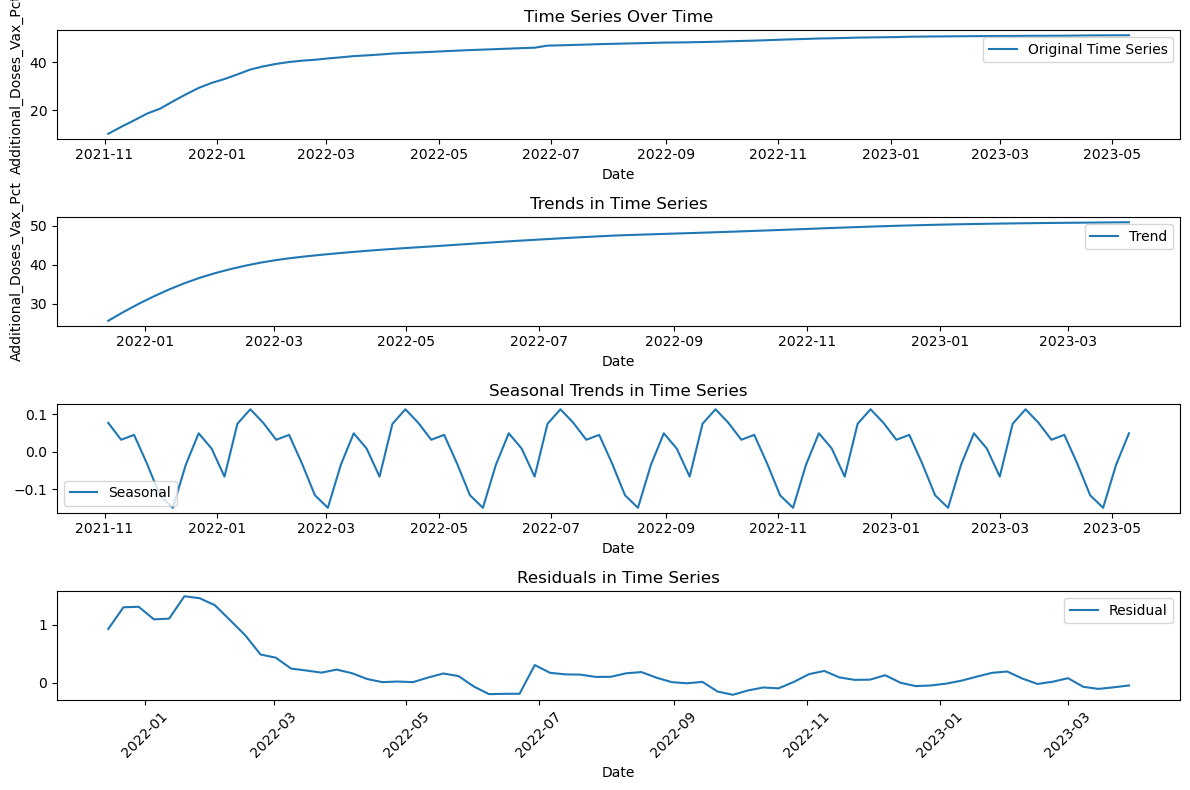

In [8]:
# STL decomposition to investigating trends, seasons and residual

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Perform STL decomposition with a known seasonality period (e.g., 12 for monthly data)
result = sm.tsa.seasonal_decompose(time_series_data[pred_var], model='stl', period=12)

# Access the decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

# Plot a subset of data (e.g., every 30th data point)
plt.subplot(4, 1, 1)
plt.plot(time_series_data[pred_var], label='Original Time Series')
plt.legend()
plt.title('Time Series Over Time')
plt.xlabel('Date')
plt.ylabel(pred_var)


plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
plt.title('Trends in Time Series')
plt.xlabel('Date')
plt.ylabel(pred_var)



plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Trends in Time Series')
plt.xlabel('Date')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()
plt.title('Residuals in Time Series')
plt.xlabel('Date')

# Customize x-axis labels to rotate by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


We have used the STL decomposition to investigate potential trends, seasons and residuals. Based on the STL plot, we have learned that `Additional Doses Vax Pct` has a very steep increase in the first 4-5 months after its initial release and then the rate has tapered and increased at a small and steady rate. This was expected as most people who wanted the booster, receved it when it first came out. The seasonal plot provides clear evidence for a seasonal pattern. This pattern is something we kept in mind and explored further in variable analysis. We will have to account for this pattern in a variety of ways moving forward with the project. For example one of the solutions is to use an ARIMA model which can account for seasonal components. However, for other models we have creaed a categorical `Season` variable. Lastly, the Residual pattern suggests that teh STL may not have adequately captured some underlying patterns or structures in our time series data. 

### Correlation Analysis:

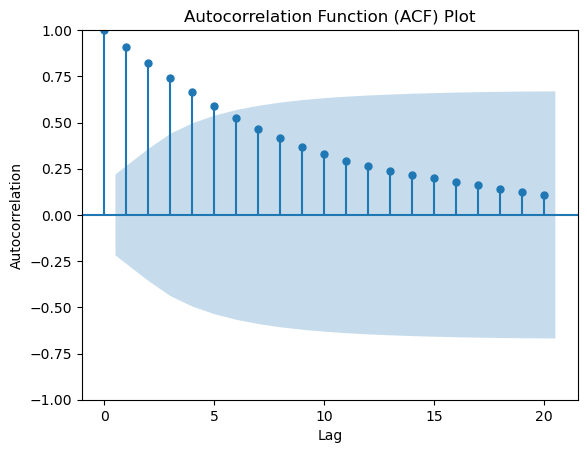

In [9]:
# ACF plot

# Create the ACF plot
plot_acf(time_series_data[pred_var])

# Customize the plot (optional)
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Show the plot
plt.show()

This ACF pattern is commonly observed in time series data with a strong short-term memory or persistence. It implies that the most recent values have a more pronounced impact on the current value, and the impact of earlier values diminishes gradually. The decay in autocorrelation suggests a relatively fast decrease in correlation with increasing time lags. Autoregressive models are ideal for dealing with this particular autocorrelation pattern.
To investigate this further we have looked at the PACF graph and identified the biggest spike at value of 1. Autoregressive models are  To deal with this particular autocorrelation pattern  To prevent correlation issues in our model we added a new lag variable with the shift of 1 week to our dataset.

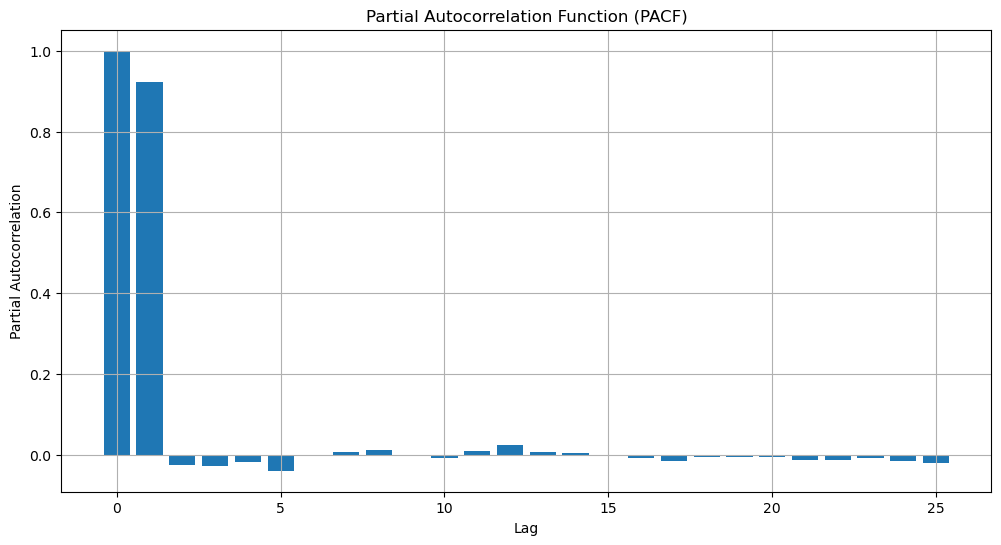

In [10]:
# PACF Plot

# Calculate the PACF
pacf = sm.tsa.pacf(time_series_data, nlags=25)

# Create the PACF plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(pacf)), pacf)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

In [11]:
df['Additional_Doses_Vax_Pct_1_w_lag'] = df['Additional_Doses_Vax_Pct'].shift(1)

In [12]:
features_target = df[['day_of_week',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 
                      'season', 'holidays', 'holiday_season', 'vax_announcement',
       'Additional_Doses_Vax_Pct_1_w_lag', pred_var,'Date']]
features_target = features_target.set_index('Date')

### Stationarity Analysis:

In [13]:
X = time_series_data.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.009253
p-value: 0.001363
Critical Values:
	1%: -3.518
	5%: -2.900
	10%: -2.587


To chek if our data is stationary we have performed the ADF test. With the null hypothesis staing that the data is not stationary. Since our $p-value \le 0.05$, we had sufficient evidence to reject the null hypothesis ($H_0$), therefore the data does not have a unit root and is stationary. This finding is helpful as it means we can move forward with an ARIMA model with no further data modifications.

### Univariate Analysis:
#### Distribution of Response Variable
Here, we can see that the response variable is skewed to the leftand that the most significant concentration of data lies between the 30% to 50% vaccination rate, suggesting that for many samples, the percentage of additional doses administered falls within this range. It's worth noting the scarcity of data points both below 10% and above 60%. This indicates that very low and very high vaccination rates are less common among the samples we have.

<Axes: xlabel='Additional_Doses_Vax_Pct', ylabel='Count'>

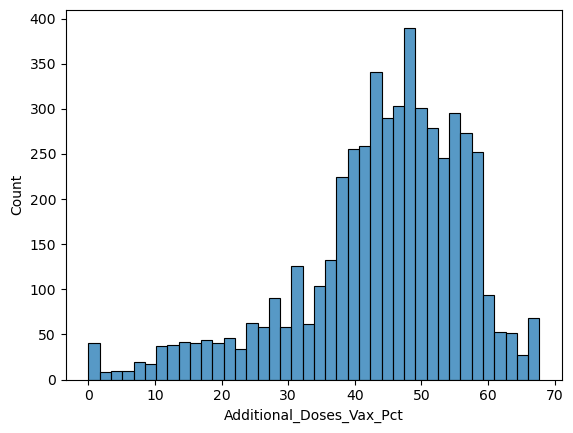

In [14]:
# Distribution of response variable
sns.histplot(df[pred_var], kde=False )

#### Distribution of features after data cleaning and imputation

We can see that many of the features are relatively normally distributted with some having an extreme skew. As we develop the models, we may apply log transformations to those with extreme skews if we feel it is necessary.

In [ ]:
# Distribution of features after data cleaning and imputation

# find continous/ numerical variables
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# plot d
%matplotlib inline
df.hist (column= continuous_vars,figsize= (50,30))
#hides array names that are otherwise printed
_ = plt.plot()

#### Distribution of feature-engineered `season`

We can see that there are more observations from the winter. This may have been because of where we start and end out data as a result of vaccine guidelines for 5-11 year olds.

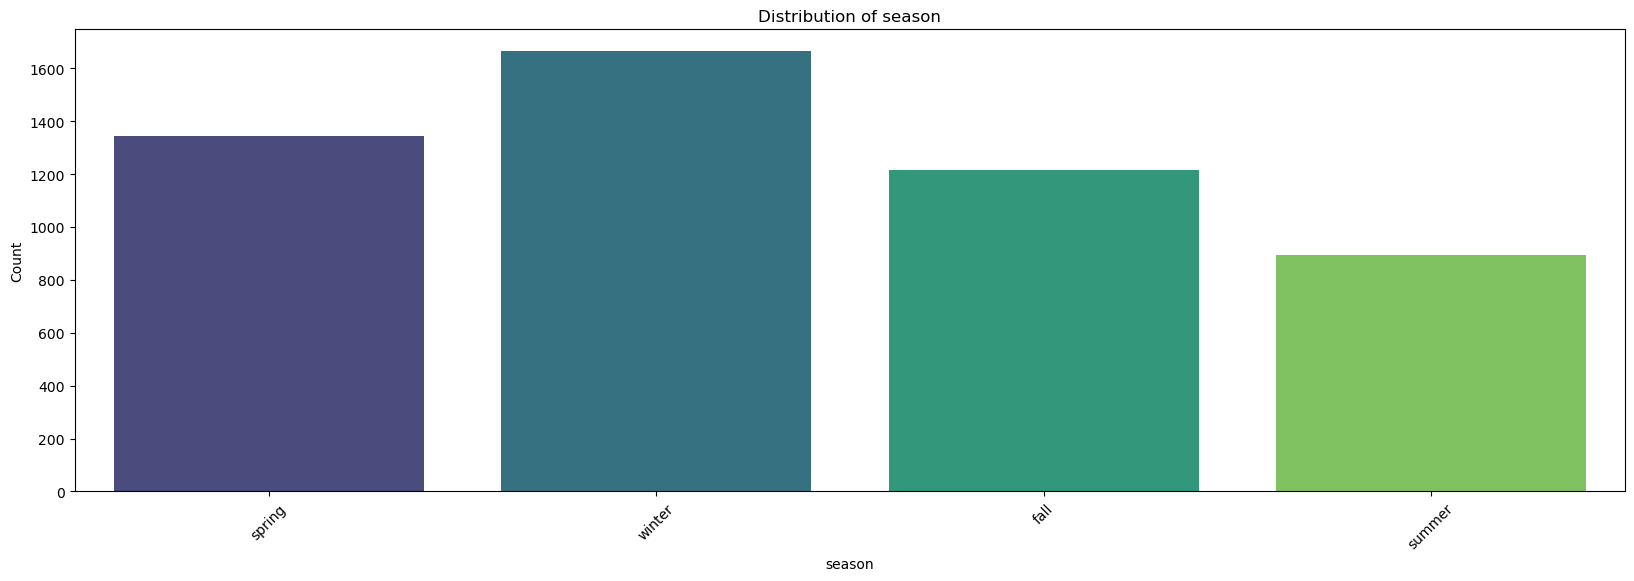

In [16]:
# Distribution of season 
categorical_variable = 'season'

# Create a countplot
plt.figure(figsize=(20, 6))  
sns.countplot(data=df, x=categorical_variable, palette='viridis')  
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability 
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Distribution of feature-engineered `holiday_season`

We can observe that relatively few vaccination rates were reported in weeks when there was a US holiday. It will be interesting to see if this features affects the models greatly.

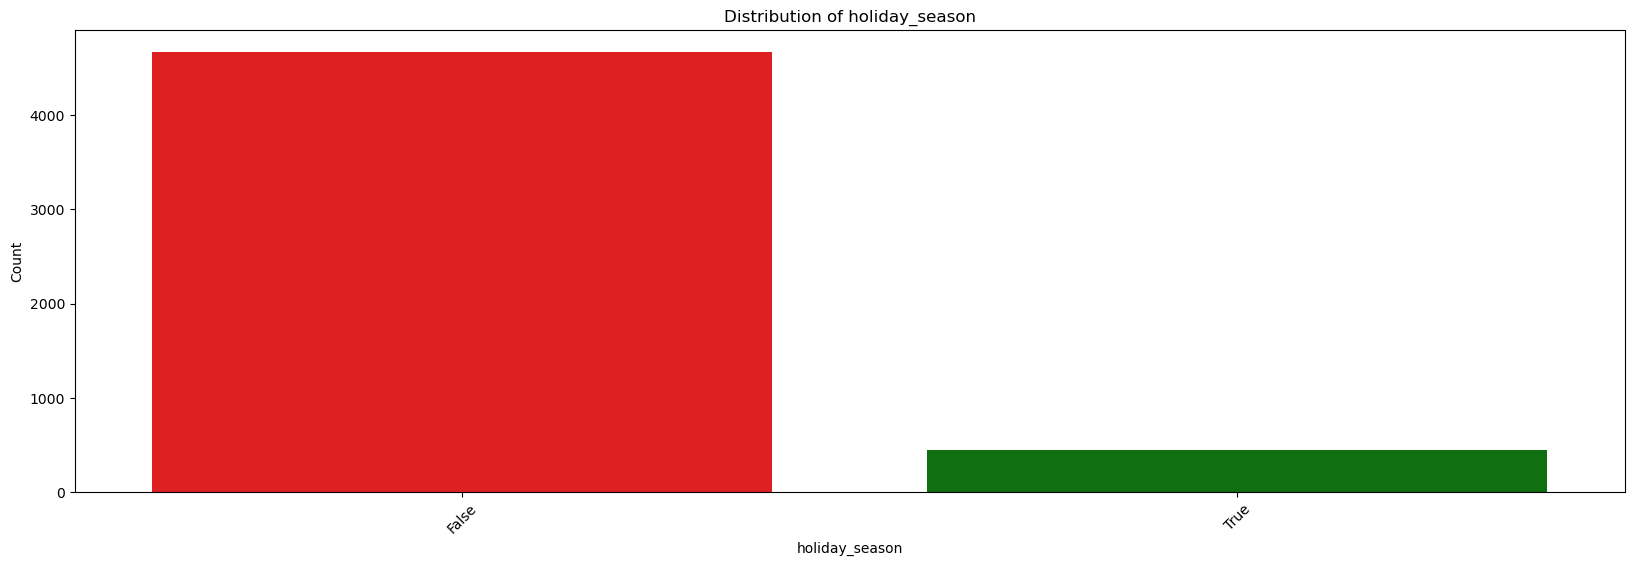

In [17]:
# Custom Boolean color palette
boolean_palette = {True: 'green', False: 'red'}

# Distribution of holidays
categorical_variable = 'holiday_season'

# Create a countplot
plt.figure(figsize=(20, 6))  
sns.countplot(data=df, x=categorical_variable, palette=boolean_palette) 
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability 
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Distribution of feature-engineered `vax_announcement`

There are a pretty significant proportiion of vaccine rate observations on a week where there was a CDC vaccine announcement. This could be because there were a lot of announcements reported, though.

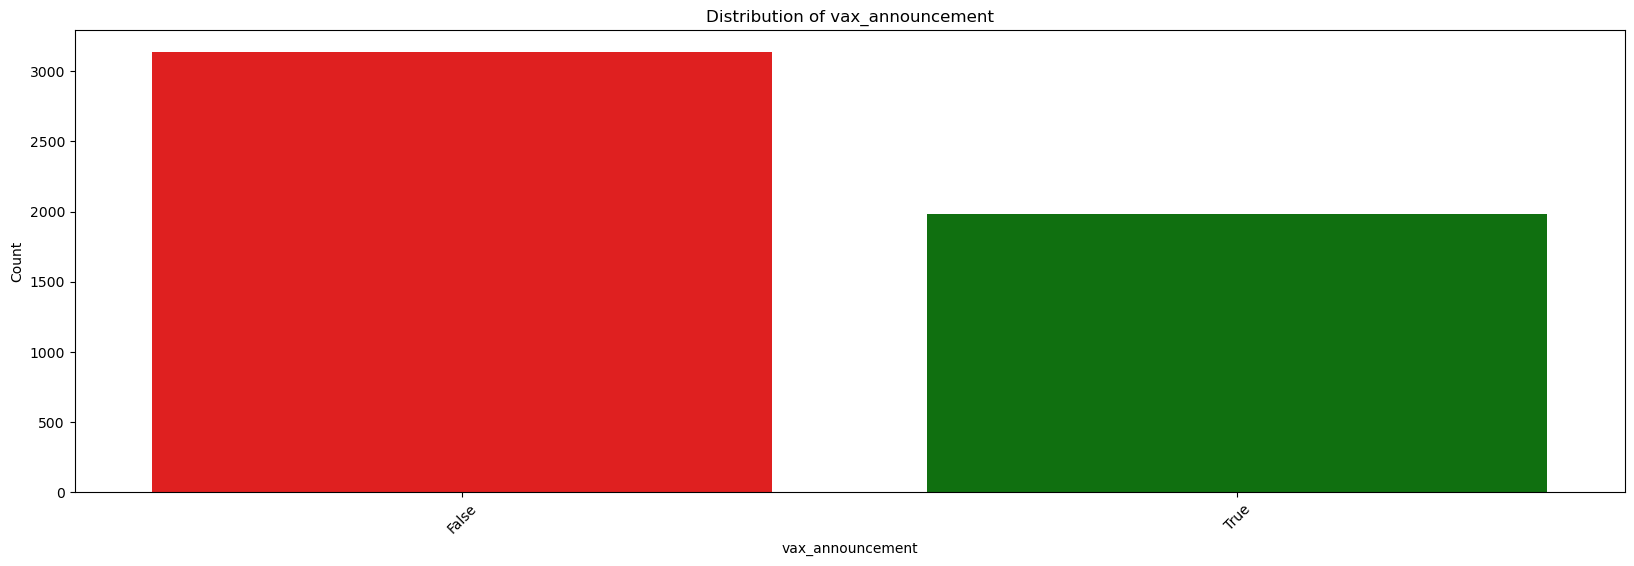

In [18]:
# Distribution of doses near vaccine announcements
categorical_variable = 'vax_announcement'

# Create a countplot
plt.figure(figsize=(20, 6))  # Set the figure size
sns.countplot(data=df, x=categorical_variable, palette=boolean_palette)  
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Distribution of `Location`
The observations across locations are almost completely even with around 15 less reports from Palau and around 60 less reports from the location code RP (we were unable to find this location's corresponding state/territory name). We will monitor whether this will affect model development or accuracy.

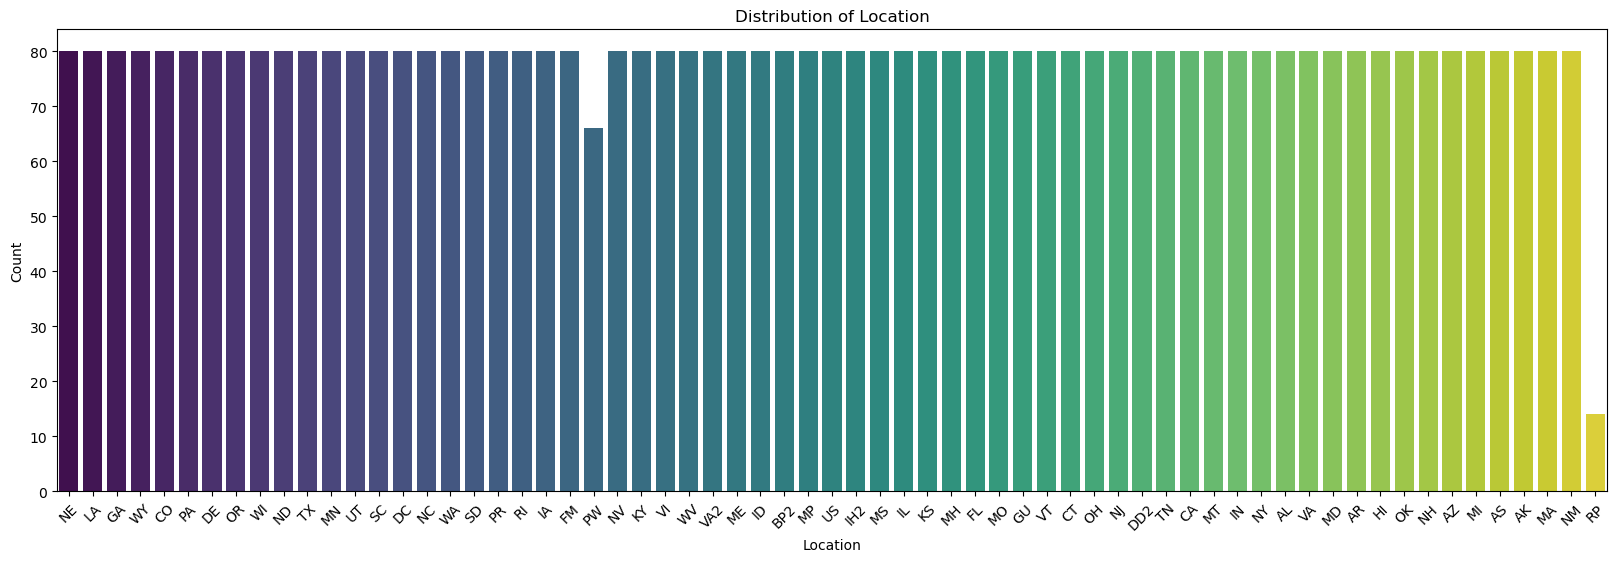

In [19]:
# Distribution of Location
categorical_variable = 'Location'

# Create a countplot
plt.figure(figsize=(20, 6))  
sns.countplot(data=df, x=categorical_variable, palette='viridis')  
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability 
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Bivariate Analysis:

To further investigate the seasonal trends found in the STL decomposition plots we have plotted box plots of `Month` and `Season` against our prediction variable. Based on these plots we can see that the median across all categories is pretty similar. However, both November and Fall have a significanly larger IQR. This is potentially related to the fact that our data subset starts in Novemember (Fall), meaning that it had a lot of low % values in 2021 when the COVID booster first came out.

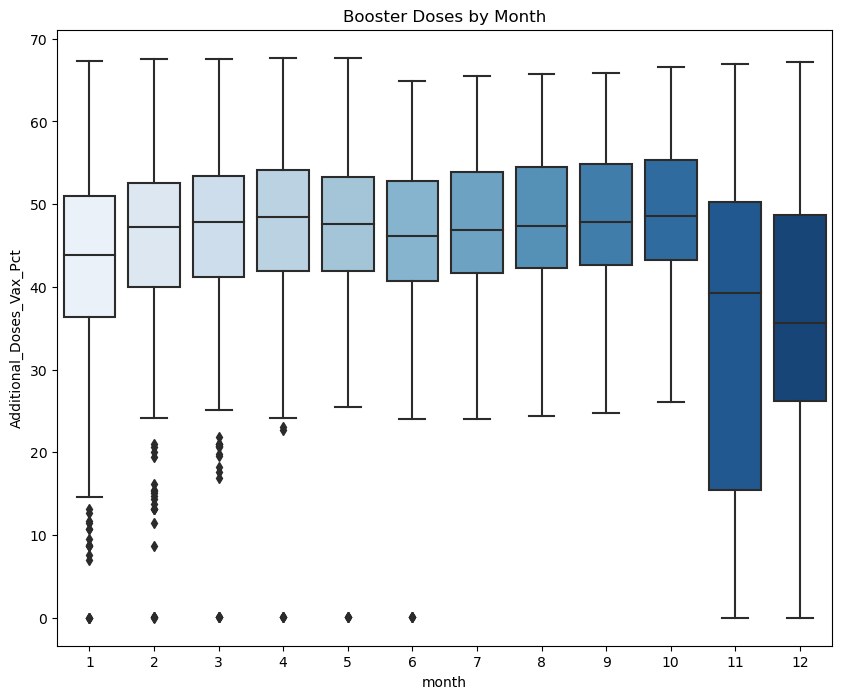

In [20]:
# visualize the monthly pred_var
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=features_target, x='month', y=pred_var, palette='Blues')
ax.set_title('Booster Doses by Month')
plt.show()

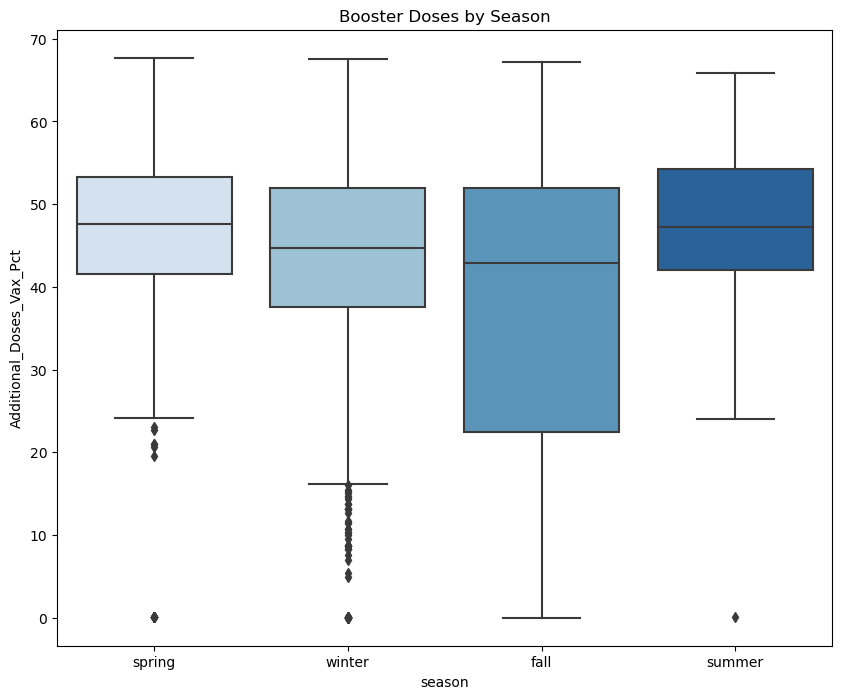

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=features_target, x='season', y=pred_var, palette='Blues')
ax.set_title('Booster Doses by Season')
plt.show()

### Multivariate Analysis:

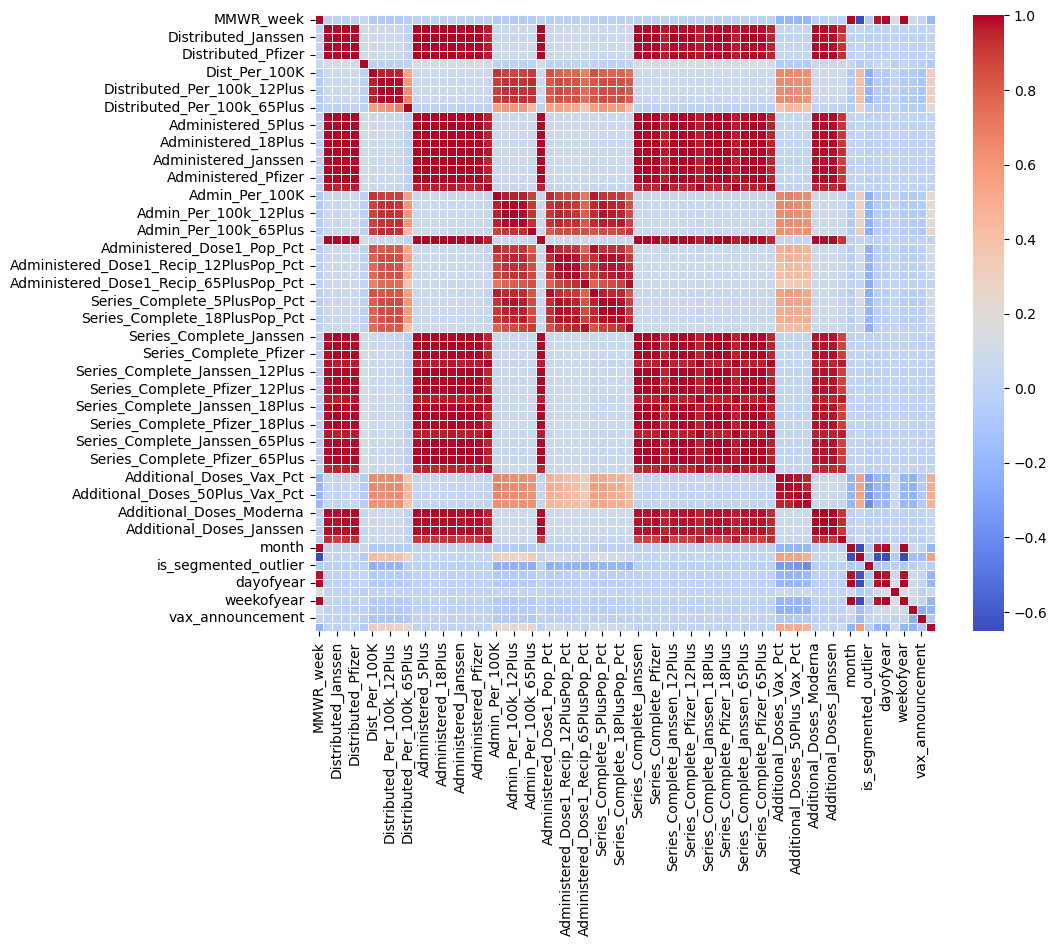

In [23]:
# heat map to show correlation between variables

plt.figure(figsize=(10, 8))  
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)

plt.show()

<Axes: >

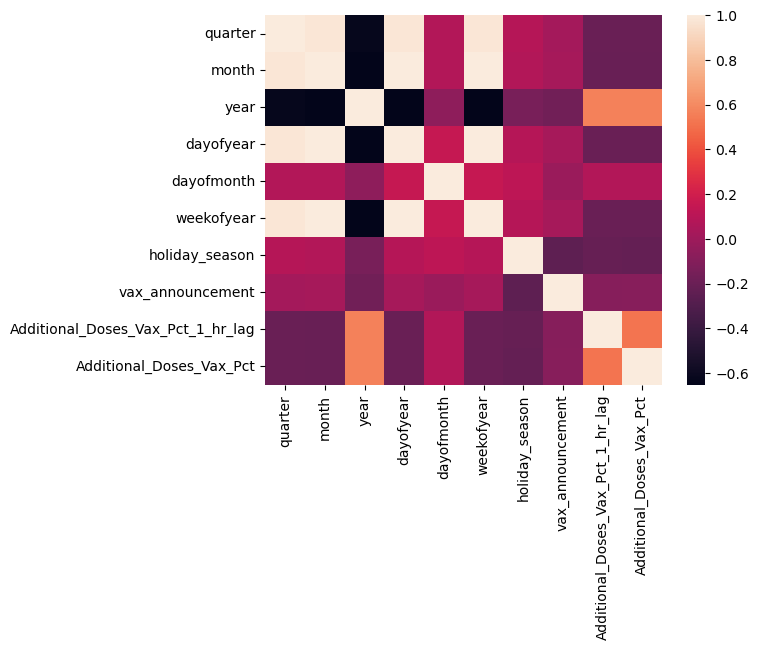

In [24]:
correlation = features_target.corr( method='pearson' )
sns.heatmap( correlation )

Based on multivariate heatmaps there are few variables that have relatively high correlation with our prediction variable. These features will have to be investigated further when we are working on variable selection for our prediction models. We have not performed in depth analysis on this so far as we are prioritizing working on time series forcasting models such as ARIMA which only include the history of the prediction variable.

# Conclusion & Next Steps


Overall the EDA and data processing we have performed so far allowed us to gain a lot of inisght into our data.
Our next goal is to start developing different prediction models. For time series forcasting model we will use the grouped by `Date` data. One of the first models we will develop is ARIMA, which we know is suitable for our stationary data and through tuning it will account for any trend patterns in the prediction variable over time. There is also possibility of using the ARIMAX model which takes into accoutn other selected features.  We will also start working on other prediction models such as Random Forest and Boosting Models (XGBoost etc.) For these models that we will be using the ungrouped data and will have to perform further investigation into the correlation between prediction variable and other features.

In [22]:
# Export as CSV
df.to_csv('df_post_eda.csv', index=False)

# References

Abulkhair, A. (2023, June 13). Data Imputation Demystified | Time Series Data | by Ahmed Abulkhair. Medium. Retrieved October 25, 2023, from https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7

Hahn, S. (n.d.). COVID-19 Vaccines. FDA. Retrieved October 25, 2023, from https://www.fda.gov/emergency-preparedness-and-response/coronavirus-disease-2019-covid-19/covid-19-vaccines

Kates, J., Tolbert, J., & Rouw, A. (2021, December 8). An Update on Vaccine Roll-Out for 5-11 Year-olds in the U.S. KFF. Retrieved October 25, 2023, from https://www.kff.org/coronavirus-covid-19/issue-brief/an-update-on-vaccine-roll-out-for-5-11-year-olds-in-the-u-s/

Montel, M. (2017). holidays · PyPI. PyPI. Retrieved October 25, 2023, from https://pypi.org/project/holidays/
